In [19]:
import matplotlib.pyplot as plt
import networkx as nx
import random

# to generate a map, we first generate some random zones, and then generate locations within each zone that are relevant to the zone.

# each zone is given a random depth, and each location within a zone is assigned a random depth

# then we connect each location within a zone to other locations within the same zone, but a location may only be connected either to another location at the same depth, or another location that is at a depth that is plus or minus one.

# We then connect each in the same way, so that zones that share the same depth can be connected, or zones that have a depth that differs only by plus or minus one can be connected.

# And by doing this we end up with a map that can be navigated by the players, but makes somewhat logical sense in how it is connected.
def generate_map(n_zones=3, min_locations=3,max_locations=6, max_depth=3):
    zone_names = ['woodland','old ruins','bog','marsh','watchtower','abandoned keep','village','forest',"outpost","cave","river","mountain","lake","waterfall","beach","coast","cliff","canyon","desert","oasis","dunes","jungle","swamp","volcano","island","grassland","shrubland","wetland""estuary"]
    G = nx.Graph()

    # Create the zones and locations with associated depth
    zone_depths = [random.randint(1, max_depth) for _ in range(n_zones)]
    zones = [f"{zone_names[i]}" for i in range(n_zones)]
    for zone, depth in zip(zones, zone_depths):
        n_locations=random.randint(min_locations,max_locations)
        loc_depths = [random.randint(1, max_depth) for _ in range(n_locations)]
        for j in range(n_locations):
            loc = f"{zone}_{j}"
            G.add_edge(zone, loc, depth=loc_depths[j])

        # Connect each location to at least one other location in the same zone
        for i in range(n_locations):
            loc1 = f"{zone}_{i}"
            if G.degree(loc1) == 1:  # Connect to another location only if it has no other connections
                other_locs = [f"{zone}_{j}" for j in range(n_locations) if j != i]
                loc2 = random.choice(other_locs)
                G.add_edge(loc1, loc2, depth=min(loc_depths[i], loc_depths[other_locs.index(loc2)]))

        # Connect locations within a zone respecting the depth rule
        for i in range(n_locations-1):
            for j in range(i+2, n_locations):
                if abs(loc_depths[i] - loc_depths[j]) <= 1:
                    loc1 = f"{zone}_{i}"
                    loc2 = f"{zone}_{j}"
                    G.add_edge(loc1, loc2, depth=min(loc_depths[i], loc_depths[j]))

    # Connect zones through locations respecting the depth rule
    for i in range(n_zones-1):
        for j in range(i+1, n_zones):
            if abs(zone_depths[i] - zone_depths[j]) <= 1:
                # Pick one random location from each zone
                n_loc_i = len([n for n in G.neighbors(zones[i])])
                n_loc_j = len([n for n in G.neighbors(zones[j])])

                loc1 = f"{zones[i]}_{random.randint(0, n_loc_i-1)}"
                loc2 = f"{zones[j]}_{random.randint(0, n_loc_j-1)}"
                G.add_edge(loc1, loc2, depth=min(zone_depths[i], zone_depths[j]))

    return G, zones, zone_depths

# remove the zones, we no longer need to know about them, we're just interested in the locations
def remove_zones(G, zones):
    for zone in zones:
        if zone in G:
            G.remove_node(zone)

    return G


In [20]:
# a map is represented as a graph, at the top is the environment, and an environment encompasses a number of distinct zones, and within each zone there is a related set of locations.

the_graph, the_zones, the_depths = generate_map(12)
the_graph = remove_zones(the_graph, the_zones)


In [21]:
def find_unreachable_pairs(G):
    nodes = list(G.nodes())
    unreachable_pairs = []

    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            if not nx.has_path(G, nodes[i], nodes[j]):
                unreachable_pairs.append(frozenset([nodes[i], nodes[j]]))

    # Eliminate duplicates
    unreachable_pairs = list(set(unreachable_pairs))

    # Get separate groups of unreachable nodes
    groups = []
    for pair in unreachable_pairs:
        for group in groups:
            if pair.intersection(group):
                group.update(pair)
                break
        else:
            groups.append(set(pair))

    return groups

def connect_islands(G):
    groups = find_unreachable_pairs(G)

    while len(groups) > 1:  # More than one group means there are unreachable nodes
        # Select two different groups
        group1, group2 = random.sample(groups, 2)

        # If a group has only one node, connect this node with a node from a different group
        if len(group1) == 1 and len(group2) > 1:
            node1 = list(group1)[0]
            node2 = random.choice([node for node in group2 if node != node1])
        elif len(group2) == 1 and len(group1) > 1:
            node1 = random.choice([node for node in group1 if node != list(group2)[0]])
            node2 = list(group2)[0]
        else:
            node1, node2 = random.sample(list(group1) + list(group2), 2)

        G.add_edge(node1, node2)

        # Recalculate groups of unreachable nodes
        groups = find_unreachable_pairs(G)

    return G



In [22]:
the_graph = connect_islands(the_graph)


In [23]:

# Printing the adjacency list of each node
# for line in nx.generate_adjlist(the_graph):
#     print(line)
#
# # Print the depth of each zone
# for zone, depth in zip(the_zones, the_depths):
#     print(f"{zone} depth: {depth}")


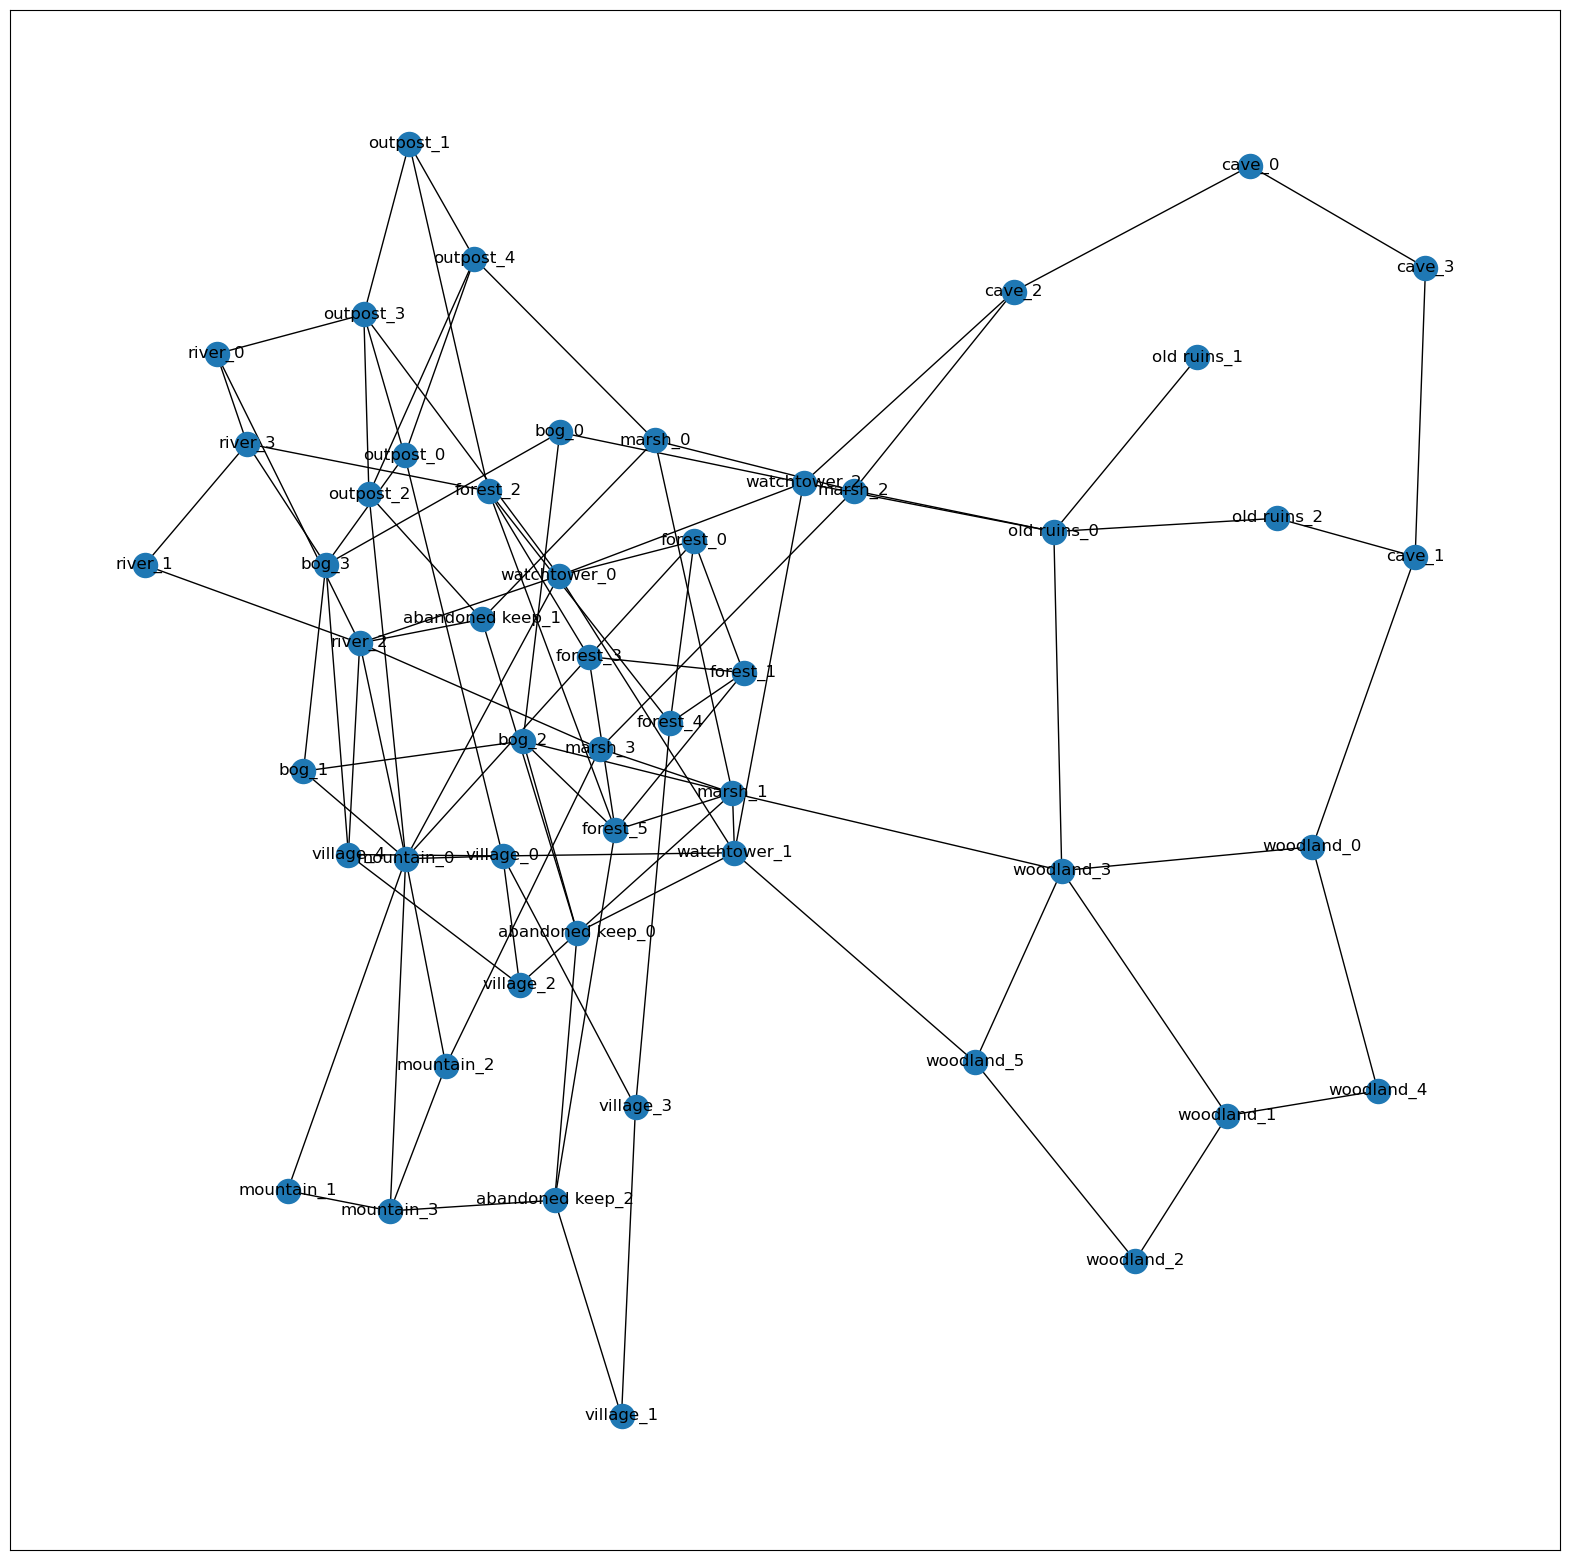

In [24]:
plt.figure(figsize=(20, 20))
nx.draw_networkx(the_graph, with_labels=True)